# Vehicle Detection and Tracking Project

### Import needed data

In [1]:
import os
import cv2
import math
import pickle
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Define data set image paths for both positive and negative domains

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

### Collect Data set images

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


### Define to access both image pixel values and labels

In [5]:
imgPxlVal = 0
img_Label = 1

## Visualize DataSet

In [6]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) == len(labels)
    assert len(images) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [ ]:
vis_imgs = []
vis_labels = []

#show 12 random images from Car dataset
for i in range(12):
    index = randint(0, len(CarImageSet))
    vis_imgs.append(CarImageSet[index][imgPxlVal])
    vis_labels.append('Car')

#show 12 random images from Not Car dataset
for i in range(12):
    index = randint(0, len(NonCarImageSet))
    vis_imgs.append(NonCarImageSet[index][imgPxlVal])
    vis_labels.append('Not Car')

pltImages(vis_imgs, vis_labels, 2, 12, 16, 4)

### Visualize color space features using histograms

In [7]:
def pltHistograms(hists, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, xlim = [0,256]):
    assert len(hists) == len(labels)
    assert len(hists) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(hists)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        plt.plot(hists[index])
        plt.xlim(xlim)
    
    plt.tight_layout()
    plt.show()

In [8]:
Channel_0 = 0
Channel_1 = 1
Channel_2 = 2

histSize = [48]
histrange = [0,255]

ColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']

In [ ]:
def ExploreColorSpaceHistogram(img):
    hist = []
    hist_label = []

    hist_0 = cv2.calcHist(img,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(img,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(img,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("RGB_Channel 0")
    hist.append(hist_1)
    hist_label.append("RGB_Channel 1")
    hist.append(hist_2)
    hist_label.append("RGB_Channel 2")

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hist_0 = cv2.calcHist(HSV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HSV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HSV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HSV_Channel 0")
    hist.append(hist_1)
    hist_label.append("HSV_Channel 1")
    hist.append(hist_2)
    hist_label.append("HSV_Channel 2")

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hist_0 = cv2.calcHist(HLS,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(HLS,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(HLS,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("HLS_Channel 0")
    hist.append(hist_1)
    hist_label.append("HLS_Channel 1")
    hist.append(hist_2)
    hist_label.append("HLS_Channel 2")

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hist_0 = cv2.calcHist(LAB,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LAB,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LAB,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LAB_Channel 0")
    hist.append(hist_1)
    hist_label.append("LAB_Channel 1")
    hist.append(hist_2)
    hist_label.append("LAB_Channel 2")

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hist_0 = cv2.calcHist(YUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("YUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("YUV_Channel 2")

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hist_0 = cv2.calcHist(LUV,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(LUV,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(LUV,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("LUV_Channel 0")
    hist.append(hist_1)
    hist_label.append("LUV_Channel 1")
    hist.append(hist_2)
    hist_label.append("LUV_Channel 2")
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hist_0 = cv2.calcHist(YCrCb,[Channel_0],None,histSize,histrange)
    hist_1 = cv2.calcHist(YCrCb,[Channel_1],None,histSize,histrange)
    hist_2 = cv2.calcHist(YCrCb,[Channel_2],None,histSize,histrange)
    hist.append(hist_0)
    hist_label.append("YCrCb_Channel 0")
    hist.append(hist_1)
    hist_label.append("YCrCb_Channel 1")
    hist.append(hist_2)
    hist_label.append("YCrCb_Channel 2")

    pltHistograms(hist, hist_label, 7, 3, xlim = [0, histSize[0]-1])

In [ ]:
#CarImageIndex = 0
CarImageIndex = randint(0, len(CarImageSet))
CarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
CarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(CarImage, CarImageLabel, 1, 1)
ExploreColorSpaceHistogram(CarImage[0])

#NonCarImageIndex = 0
NonCarImageIndex = randint(0, len(NonCarImageSet))
NonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
NonCarImageLabel = [NonCarImageSet[NonCarImageIndex][img_Label]]

pltImages(NonCarImage, NonCarImageLabel, 1, 1)
ExploreColorSpaceHistogram(NonCarImage[0])

Spatial Binning

In [9]:
#Code obtained from Udacity lesson 16
def bin_spatial_Demo_colorspace(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [10]:
size=(8, 8)

In [ ]:
vis_imgs = []
vis_labels = []

index = randint(0, len(CarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(CarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([CarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

vis_imgs = []
vis_labels = []

index = randint(0, len(NonCarImageSet))

vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], size=size))
vis_labels.append('RGB')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HSV', size=size))
vis_labels.append('HSV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LUV', size=size))
vis_labels.append('LUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='HLS', size=size))
vis_labels.append('HLS')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YUV', size=size))
vis_labels.append('YUV')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='YCrCb', size=size))
vis_labels.append('YCrCb')
vis_imgs.append(bin_spatial_Demo_colorspace(NonCarImageSet[index][imgPxlVal], color_space='LAB', size=size))
vis_labels.append('LAB')

pltImages([NonCarImageSet[index][imgPxlVal]], ["Original Image"], 1, 1, 20, 2)
pltHistograms(vis_imgs, vis_labels, 7, 1, xlim = [0, 200])

#### I started with resize to 32*32 but the output proved to be very large, 3072, which I consider very large for a soft qualifier like this and better to be downsampled to 8*8

#### All color spaces provide different signatures between the two classes, take RGB for simplicity

### Visualize HOG features

In [11]:
def get_hog_features_demo(img, orient, pix_per_cell, cell_per_block, blockNorm, trns_sqrt, visualize=False, feature_vec=True):
    if visualize == True:
        features, hog_im = hog(img,
                               orientations=orient,
                               pixels_per_cell=(pix_per_cell, pix_per_cell),
                               cells_per_block=(cell_per_block, cell_per_block),
                               block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                               transform_sqrt=trns_sqrt, 
                               visualise=visualize,
                               feature_vector=feature_vec)
        return features, hog_im
    else:      
        features = hog(img,
                       orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm = blockNorm, #Block Normalize didn't show any change effect on image
                       transform_sqrt=trns_sqrt, 
                       visualise=visualize,
                       feature_vector=feature_vec)
        return features

In [ ]:
orient = 8
pix_per_cell = 16
cells_per_block = 2
TransformSqrt = True

blockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

hc = 'ALL'

In [ ]:
def VisauliseHOG(img):
    vis = True
    __, hog_im = get_hog_features_demo(
        img,
        orient,
        pix_per_cell,
        cells_per_block,
        'L2-Hys',
        visualize=vis,
        trns_sqrt=TransformSqrt,
        feature_vec=False)
    return hog_im

In [ ]:
def ExploreHOGSpace(img):
    HOG_IMs = []
    hog_label = []
    
    hog_0 = VisauliseHOG(img[:,:,Channel_0])
    hog_1 = VisauliseHOG(img[:,:,Channel_1])
    hog_2 = VisauliseHOG(img[:,:,Channel_2])
    pltImages([hog_0], ["RGB_Channel 0"], 1, 1)
    pltImages([hog_1], ["RGB_Channel 1"], 1, 1)
    pltImages([hog_2], ["RGB_Channel 2"], 1, 1)

    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    hog_0 = VisauliseHOG(HSV[:,:,Channel_0])
    hog_1 = VisauliseHOG(HSV[:,:,Channel_1])
    hog_2 = VisauliseHOG(HSV[:,:,Channel_2])
    pltImages([hog_0], ["HSV_Channel 0"], 1, 1)
    pltImages([hog_1], ["HSV_Channel 1"], 1, 1)
    pltImages([hog_2], ["HSV_Channel 2"], 1, 1)

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    hog_0 = VisauliseHOG(HLS[:,:,Channel_0])
    hog_1 = VisauliseHOG(HLS[:,:,Channel_1])
    hog_2 = VisauliseHOG(HLS[:,:,Channel_2])
    pltImages([hog_0], ["HLS_Channel 0"], 1, 1)
    pltImages([hog_1], ["HLS_Channel 1"], 1, 1)
    pltImages([hog_2], ["HLS_Channel 2"], 1, 1)

    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    hog_0 = VisauliseHOG(LAB[:,:,Channel_0])
    hog_1 = VisauliseHOG(LAB[:,:,Channel_1])
    hog_2 = VisauliseHOG(LAB[:,:,Channel_2])
    pltImages([hog_0], ["LAB_Channel 0"], 1, 1)
    pltImages([hog_1], ["LAB_Channel 1"], 1, 1)
    pltImages([hog_2], ["LAB_Channel 2"], 1, 1)

    YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    hog_0 = VisauliseHOG(YUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(YUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(YUV[:,:,Channel_2])
    pltImages([hog_0], ["YUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["YUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["YUV_Channel 2"], 1, 1)

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    hog_0 = VisauliseHOG(LUV[:,:,Channel_0])
    hog_1 = VisauliseHOG(LUV[:,:,Channel_1])
    hog_2 = VisauliseHOG(LUV[:,:,Channel_2])
    pltImages([hog_0], ["LUV_Channel 0"], 1, 1)
    pltImages([hog_1], ["LUV_Channel 1"], 1, 1)
    pltImages([hog_2], ["LUV_Channel 2"], 1, 1)
    
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    hog_0 = VisauliseHOG(YCrCb[:,:,Channel_0])
    hog_1 = VisauliseHOG(YCrCb[:,:,Channel_1])
    hog_2 = VisauliseHOG(YCrCb[:,:,Channel_2])
    pltImages([hog_0], ["YCrCb_Channel 0"], 1, 1)
    pltImages([hog_1], ["YCrCb_Channel 1"], 1, 1)
    pltImages([hog_2], ["YCrCb_Channel 2"], 1, 1)

In [ ]:
CarImageIndex = 0
#CarImageIndex = randint(0, len(CarImageSet))
HOGCarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGCarImage[0])

NonCarImageIndex = 0
#NonCarImageIndex = randint(0, len(NonCarImageSet))
HOGNonCarImage = [NonCarImageSet[NonCarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGNonCarImage, HOGCarImageLabel, 1, 1)
ExploreHOGSpace(HOGNonCarImage[0])

# Enough Visualization :D, Let's Extract Some Features

In [12]:
def normalize(data):
    return preprocessing.normalize(data)

In [59]:
AllowedColorSpace = ['RGB','HSV','HLS', 'LAB', 'YUV', 'LUV', 'YCrCb']
AllowedblockNorm = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']

#Calibration Parameters
CHist_EN=True
SB_EN=False
HOG_EN=False
Nrmlz=True

#Color Histogram
histSize = [48]
histrange = [0,255]
Hist_colorspace = "RGB"
CS_Ch_Idx = "All"

#Spatial Binning
size=(8, 8)
SB_colorspace = "RGB"

#HOG Params
HOG_colorspace = "RGB"
orient = 12
pix_per_cell = 16
cells_per_block = 4
blk_Norm = "L2-Hys"
TransformSqrt = True
feat_vec = True
HOG_Ch_Idx = "All"

In [64]:
def extractFeatures(img,debug=False,ReturnSizes=False):
    
    hist_feat = []
    SB_feat = []
    hog_feat = []
    
    hist_feat_shape = 0
    SB_feat_shape   = 0
    hog_feat_shape  = 0
    
    histrange = [0,255]
    
    if CHist_EN == True:
        #Extract Color Hitogram Features
        if Hist_colorspace == "HSV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            hist_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume RGB No action needed
            hist_image = np.copy(img)
        
        if CS_Ch_Idx != "All":
            hist_feat = cv2.calcHist(hist_image,[CS_Ch_Idx],None,histSize,histrange)
        else:
            hist_feat = []
            for Ch_Idx in range(hist_image.shape[2]):
                hist_feat.append(cv2.calcHist(hist_image,[Ch_Idx],None,histSize,histrange))
        
        hist_feat = np.ravel(hist_feat).reshape(1, -1)

        if debug == True:
            print("Histogram")
            print("Before Normalize")
            print(hist_feat.shape)
            print(hist_feat)
        
        if Nrmlz == True:
            hist_feat = normalize(hist_feat)
            if debug == True:
                print("After Normalize")
                print(hist_feat.shape)
                print(hist_feat)
                
        hist_feat = hist_feat[0]
        hist_feat_shape = hist_feat.shape
        
    if SB_EN == True:
        #Extract Spatial Binning Features
        if Hist_colorspace == "HSV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif Hist_colorspace == "HLS":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif Hist_colorspace == "LAB":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif Hist_colorspace == "YUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif Hist_colorspace == "LUV":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif Hist_colorspace == "YCrCb":
            SB_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume RGB No action needed
            SB_image = np.copy(img)
        
        SB_feat = cv2.resize(SB_image, size).ravel().reshape(1, -1).astype(np.float64)

        if debug == True:
            print("Spatial Binning")
            print("Before Normalize")
            print(SB_feat.shape)
            print(SB_feat)
        
        if Nrmlz == True:
            SB_feat = normalize(SB_feat)
            if debug == True:
                print("After Normalize")
                print(SB_feat.shape)
                print(SB_feat)
                
        SB_feat = SB_feat[0]
        SB_feat_shape = SB_feat.shape
    
    if HOG_EN == True:
        #Extract HOG Features
        if HOG_colorspace == "HSV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif HOG_colorspace == "HLS":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif HOG_colorspace == "LAB":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif HOG_colorspace == "YUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif HOG_colorspace == "LUV":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif HOG_colorspace == "YCrCb":
            hog_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: #Assume RGB No action needed
            hog_image = np.copy(img)
        
        if HOG_Ch_Idx != "All":
            hog_feat = get_hog_features_demo(
                img[:,:,HOG_Ch_Idx],
                orient,
                pix_per_cell,
                cells_per_block,
                blk_Norm,
                visualize=False,
                trns_sqrt=TransformSqrt,
                feature_vec=True)
        else:
            for Ch_Idx in range(hog_image.shape[2]):
                hog_feat.append(get_hog_features_demo(
                    img[:,:,Ch_Idx],
                    orient,
                    pix_per_cell,
                    cells_per_block,
                    blk_Norm,
                    visualize=False,
                    trns_sqrt=TransformSqrt,
                    feature_vec=True))
        
        hog_feat = np.ravel(hog_feat).reshape(1, -1)
        
        if debug == True:
            print("HOG")
            print("Before Normalize")
            print(hog_feat.shape)
            print(hog_feat)
        
        if Nrmlz == True:
            hog_feat = normalize(hog_feat)
            if debug == True:
                print("After Normalize")
                print(hog_feat.shape)
                print(hog_feat)
                
        hog_feat = hog_feat[0]
        hog_feat_shape = hog_feat.shape
    
    if debug == True:
        print("Before Concatenation")
        print(hist_feat)
        print(SB_feat)
        print(hog_feat)
    
    features = np.hstack((hist_feat, SB_feat, hog_feat))
    
    if debug == True:
        print("Output")
        print(len(features))
        print(features)
    
    #features = np.ravel(features)
    
    #if debug == True:
        #print(features.shape)
        #print(features)

    if ReturnSizes == False:
        return features
    else:
        return (hist_feat_shape, 
                SB_feat_shape, 
                hog_feat_shape, 
                features)

##### Test Feature Extraction Function

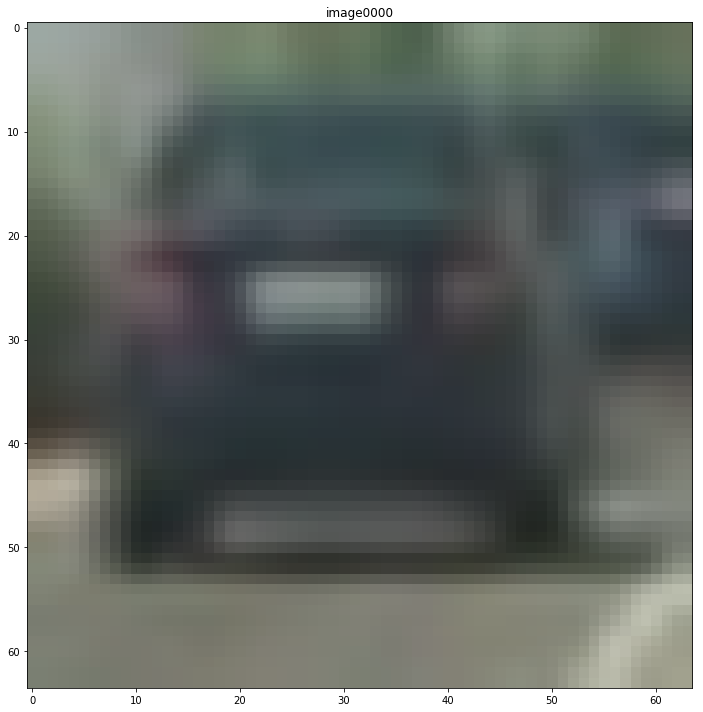

(144,)
0
0


In [66]:
CarImageIndex = 0
#CarImageIndex = randint(0, len(CarImageSet))
HOGCarImage = [CarImageSet[CarImageIndex][imgPxlVal]]
HOGCarImageLabel = [CarImageSet[CarImageIndex][img_Label]]

pltImages(HOGCarImage, HOGCarImageLabel, 1, 1)
Test = extractFeatures(HOGCarImage[0],
                       debug=False,
                       ReturnSizes=True)
print(Test[0])
print(Test[1])
print(Test[2])

In [67]:
Car_features = []
NonCar_features = []

for image in CarImageSet:
    Car_features.append(extractFeatures(image[imgPxlVal],
                                        debug=False))
print("Car Feature Collected")

for image in NonCarImageSet:
    NonCar_features.append(extractFeatures(image[imgPxlVal],
                                        debug=False))
print("Non Car Feature Collected")

Car Feature Collected
Non Car Feature Collected


In [68]:
FeatureSet = np.vstack((Car_features, NonCar_features)).astype(np.float64)
LbaelSet = np.hstack((np.ones(len(Car_features)), np.zeros(len(NonCar_features))))

In [69]:
Feature_scaler = StandardScaler().fit(FeatureSet)
Scaled_FeatureSet = Feature_scaler.transform(FeatureSet)

In [70]:
print(FeatureSet.mean())
print(FeatureSet.std())
print(Scaled_FeatureSet.mean())
print(Scaled_FeatureSet.std())

0.0388027738371
0.0737481470273
-1.78646998207e-17
1.0


In [71]:
rand_state = 20
#rand_state = np.random.randint(0, 100)
Feature_train, Feature_test, Label_train, Label_test = train_test_split(Scaled_FeatureSet, LbaelSet, test_size=0.2, random_state=rand_state)

### Train/Load Model

In [72]:
def TrainModel():
    svc = LinearSVC()
    svc.fit(Feature_train, Label_train)

    return svc

def TrainModel_WithParameterSearch():
    parameters = {'C':[1, 100]}

    svc = LinearSVC()
    clf = GridSearchCV(svc, parameters)
    clf.fit(X_train, y_train)

    return clf

#below code is obtained from http://scikit-learn.org/stable/modules/model_persistence.html
def SaveModel(clf):
    s = pickle.dumps(clf)
    joblib.dump(clf, 'TrainedModel.pkl')

def LoadModel():
    return joblib.load('TrainedModel.pkl') 

In [73]:
print("Training")
clf = TrainModel()
SaveModel(clf)

#clf = LoadModel()

Training


### Test Model

In [74]:
print('Test Accuracy of SVC = ', clf.score(Feature_test, Label_test))

for i in range(10):
    print('My SVC predicts: ', clf.predict(Feature_test[i].reshape(1, -1)), 'for label: ', Label_test[i])

Test Accuracy of SVC =  0.780123873874
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 1.] for label:  0.0
My SVC predicts:  [ 1.] for label:  1.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 0.] for label:  0.0
My SVC predicts:  [ 1.] for label:  0.0
My SVC predicts:  [ 0.] for label:  1.0
My SVC predicts:  [ 1.] for label:  1.0
My SVC predicts:  [ 1.] for label:  0.0


## Expolre Different parameters as discussed in the sheet

In [75]:
PTNormalize      = 0
PTCHist_EN       = 1
PTCHist_BCnt     = 2
PTCHist_CSpace   = 3
PTCHist_Ch_Idx   = 4
PTSB_EN          = 5
PTSB_Size        = 6
PTSB_CSpace      = 7
PTHOG_EN         = 8
PTHOG_OrientCnt  = 9
PTHOG_Px_Per_Cl  = 10
PTHOG_Cl_Per_Blk = 11
PTHOG_Blk_Nrmlz  = 12
PTHOG_Trnsf_Sqrt = 13
PTHOG_CSpace     = 14
PTHOG_Ch_Indx    = 15
PTSVM_Kernel     = 16
PTSVM_Degree     = 17
PTSVM_Gamma      = 18
PTSVM_C          = 19

def ParameterTuning():
    global CHist_EN
    global SB_EN
    global HOG_EN
    global Nrmlz
    global histSize
    global Hist_colorspace
    global CS_Ch_Idx
    global size
    global SB_colorspace
    global HOG_colorspace
    global orient
    global pix_per_cell
    global cells_per_block
    global blk_Norm
    global TransformSqrt
    global HOG_Ch_Idx
    
    
    SearchTrials=[
        [False,True,[32],"RGB","All",False,0,"",False,0,0,0,"",False,"","","linear",0,0,0.5]
    ]
    
    for idx in range(0, len(SearchTrials)):
        CHist_EN  = SearchTrials[idx][PTCHist_EN]
        SB_EN     = SearchTrials[idx][PTSB_EN]
        HOG_EN    = SearchTrials[idx][PTHOG_EN]
        Nrmlz     = SearchTrials[idx][PTNormalize]
        histSize  = SearchTrials[idx][PTCHist_BCnt]
        Hist_colorspace = SearchTrials[idx][PTCHist_CSpace]
        CS_Ch_Idx = SearchTrials[idx][PTCHist_Ch_Idx]
        size      = SearchTrials[idx][PTSB_Size]
        SB_colorspace   = SearchTrials[idx][PTSB_CSpace]
        HOG_colorspace  = SearchTrials[idx][PTHOG_CSpace]
        orient    = SearchTrials[idx][PTHOG_OrientCnt]
        pix_per_cell    = SearchTrials[idx][PTHOG_Px_Per_Cl]
        cells_per_block = SearchTrials[idx][PTHOG_Cl_Per_Blk]
        blk_Norm  = SearchTrials[idx][PTHOG_Blk_Nrmlz]
        TransformSqrt   = SearchTrials[idx][PTHOG_Trnsf_Sqrt]
        HOG_Ch_Idx= SearchTrials[idx][PTHOG_Ch_Indx]
    
    Test = extractFeatures(HOGCarImage[0])
    print(Test)
    
    lCar_features = []
    lNonCar_features = []
    
    for image in CarImageSet:
        lCar_features.append(extractFeatures(image[imgPxlVal]).reshape(-1, 1))
    
    for image in NonCarImageSet:
        lNonCar_features.append(extractFeatures(image[imgPxlVal]).reshape(-1, 1))
    
    lFeatureSet = np.vstack((lCar_features, lNonCar_features)).astype(np.float64)[:,:,0]
    lLbaelSet = np.hstack((np.ones(len(lCar_features)), np.zeros(len(lNonCar_features))))
    
    print(lFeatureSet.shape)
    lFeature_scaler = StandardScaler().fit(lFeatureSet)
    lScaled_FeatureSet = lFeature_scaler.transform(lFeatureSet)
    
    lrand_state = 20
    #lrand_state = np.random.randint(0, 100)
    lFeature_train, lFeature_test, lLabel_train, lLabel_test = train_test_split(lScaled_FeatureSet, lLbaelSet, test_size=0.2, random_state=lrand_state)

ParameterTuning()

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   4.  11.  19.  17.  20.  28.
  20.  24.  17.   9.  11.  10.   2.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.  11.  19.  17.
  20.  31.  19.  22.  17.   9.  11.  10.   2.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  12.
  21.  18.  25.  32.  15.  22.  14.   8.  12.  10.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
(17760, 96)


In [ ]:
def ParameterTuning():
    